# Data Cleaning and Preprocessing

### Introduction

This document outlines the data cleaning and preprocessing steps performed on the extracted datasets in preparation for subsequent modeling. These processes are crucial to ensure data quality and compatibility for effective machine learning.

### Libraries and Data Loading

The data cleaning process starts with the importation of essential Python libraries and the previously obtained datasets from the feature extraction stage. The datasets include 'df_pyradiomics' and 'df_pylidc'.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_pyradiomics = pd.read_csv('pyradiomics_extraction_fixed.csv', index_col=False)
df_pylidc = pd.read_csv('pylidc_features_fixed.csv', index_col=False)

C:\Users\anton\AppData\Local\Temp\ipykernel_2600\3687287947.py:1: DtypeWarning: Columns (38,39,40,41,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pyradiomics = pd.read_csv('pyradiomics_extraction_fixed.csv', index_col=False)


### Binary Classification

Before merging both datasets, a binary classification approach is adopted to simplify the target variable, specifically distinguishing between malign and benign cases.

#### Default Distribution

An initial examination of the default distribution of the target variable is performed to understand the distribution of different malignancy labels.

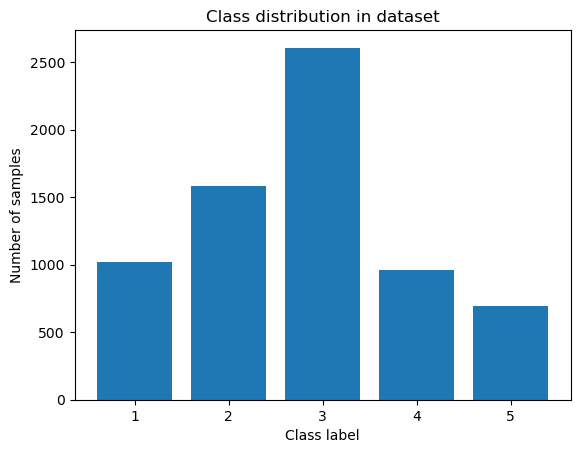

[1 2 3 4 5] [1020 1580 2606  962  691]


In [5]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Binary Transformation

The target variable is transformed into a binary classification format by merging similar classes:

- -1  -> 'Highly Unlikely' (1) and 'Moderately Unlikely' (2)  
- 0  -> 'Indeterminate' (3)  
- 1  -> 'Moderately Suspicious' (4) and 'Highly Suspicious' (5)  

In [6]:
for i in range(len(df_pylidc)):
    if df_pylidc.at[i,'malignancy'] == 1 or df_pylidc.at[i,'malignancy'] == 2:
        df_pylidc.at[i,'malignancy'] = -1
    elif df_pylidc.at[i,'malignancy'] == 4 or df_pylidc.at[i,'malignancy'] == 5:
        df_pylidc.at[i,'malignancy'] = 1
    else:
        df_pylidc.at[i,'malignancy'] = 0

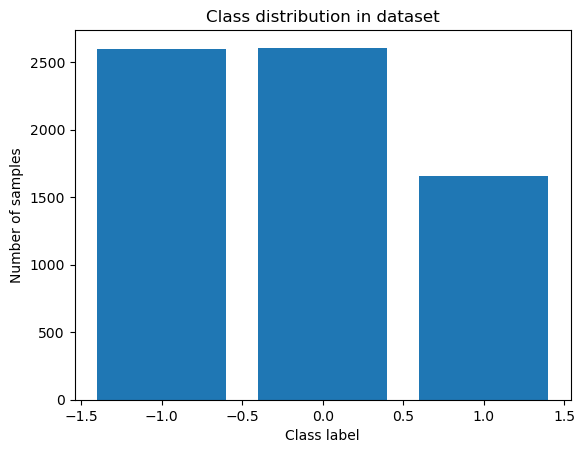

[-1  0  1] [2600 2606 1653]


In [7]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Removal of neutral cases

In this step, instances labeled as 0 are converted to the most common class within each patient, using a function, 'most_common_class' that identifies the most frequent class within a patient group.

In [8]:
def most_common_class(group):
    mode_class = group['malignancy'].mode()
    if not mode_class.empty:
        return mode_class.iloc[0]
    else:
        return 0

A dictionary is created, to store the value of the most common class for each patient and these values are assigned to instances with a malignancy label of 0.

In [9]:
most_common_per_patient = df_pylidc.groupby('patient_id').apply(most_common_class).to_dict()

df_pylidc['malignancy'] = df_pylidc.apply(lambda row: most_common_per_patient.get(row['patient_id'], row['malignancy']) if row['malignancy'] == 0 else row['malignancy'], axis=1)

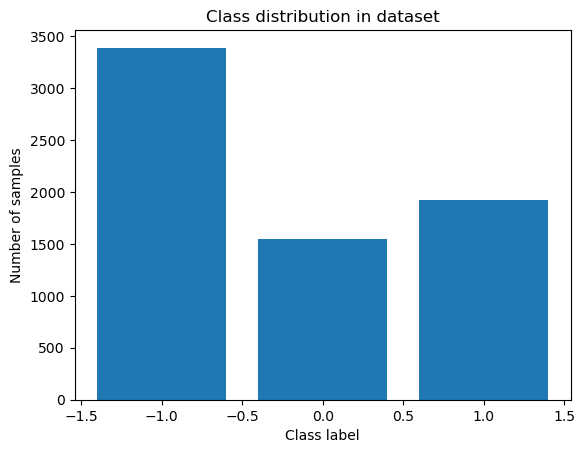

[-1  0  1] [3388 1549 1922]


In [10]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Eliminating Majority '0' Patients

Patients for whom malignancy is the majority class (0) are removed from the dataset to completely binarise the target classes.

In [11]:
diagnosis_counts = df_pylidc.groupby('patient_id')['malignancy'].value_counts().unstack(fill_value=0)

majority_0_patients = diagnosis_counts.idxmax(axis=1) == 0

df_pylidc = df_pylidc[~df_pylidc['patient_id'].isin(majority_0_patients[majority_0_patients].index)]

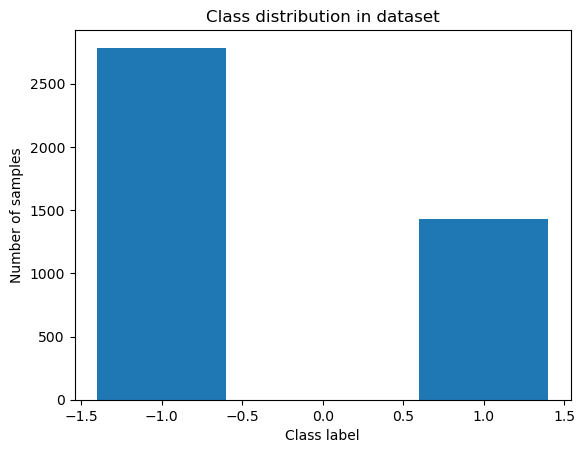

[-1  1] [2785 1433]


In [12]:
unique_labels, counts = np.unique(df_pylidc.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

In [13]:
df_pylidc.to_csv('final_pylidc_extraction.csv', sep=',', index=False)

### Features Merge

With the target variable now in the desired binary format, the next step is to merge both datasets ('df_pyradiomics' and 'df_pylidc').

In [14]:
print(df_pylidc.shape)
print(df_pyradiomics.shape)

(4218, 16)
(4696, 1599)


In [15]:
df = df_pyradiomics.merge(df_pylidc, left_on='id', right_on='Id')
df = df.drop(columns=['Id'])
df.shape

(2948, 1614)

### Columns removal

#### Null Values and Constants

Columns that are either constant or contain null values are removed to enhance dataset quality and reduce redundancy.

In [16]:
removed = 0
for col in df.columns:
    if len(df[col].unique()) == 1:
        df = df.drop(columns=col)
        removed += 1

for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        df = df.drop(columns=col)
        removed += 1

The following number of columns remained.

In [17]:
print(df.shape)
print(f"Total number of columns deleted: {removed}")

(2948, 1314)
Total number of columns deleted: 300


And the DataFrame was left with the following number of individual patients in the training set and distribution of the target class.

In [18]:
len(df['patient_id'].unique())

435

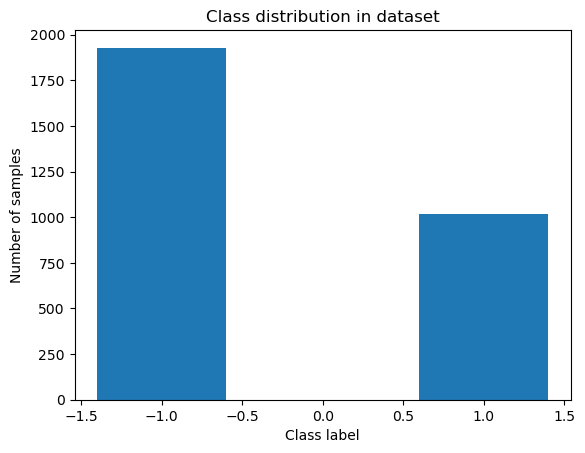

[-1  1] [1929 1019]


In [19]:
unique_labels, counts = np.unique(df.malignancy, return_counts=True)
plt.bar(unique_labels, counts)
plt.xlabel('Class label')
plt.ylabel('Number of samples')
plt.title('Class distribution in dataset')
plt.show()

print(unique_labels, counts)

#### Handling String/Object Types

String and object type columns are often problematic when dealing with machine learning tasks. Because of this, some more data processing was needed.

In [20]:
df.dtypes.value_counts()

float64    1281
object       20
int64        13
dtype: int64

In [21]:
df_groupby_dtypes = df.columns.to_series().groupby(df.dtypes).groups

for key, value in df_groupby_dtypes.items():
    if key == 'object':
        print(value)

Index(['id', 'diagnostics_Mask-original_Hash',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Image-interpolated_Spacing',
       'diagnostics_Image-interpolated_Size',
       'diagnostics_Mask-interpolated_Spacing',
       'diagnostics_Mask-interpolated_Size',
       'diagnostics_Mask-interpolated_BoundingBox',
       'diagnostics_Mask-interpolated_CenterOfMassIndex',
       'diagnostics_Mask-interpolated_CenterOfMass',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_MinorAxisLength', 'patient_id'],
      dtype='object')


After identifying the object type columns, coordinate tuples present in some string columns are split into separate x, y, and z columns for further analysis.

The remaining columns with questionable data, such as hash values or imaginary values, are removed.

In [22]:
object_columns = [
    'diagnostics_Mask-original_Spacing',
    'diagnostics_Mask-original_Size',
    'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_CenterOfMass',
    'diagnostics_Image-interpolated_Spacing',
    'diagnostics_Image-interpolated_Size',
    'diagnostics_Mask-interpolated_Spacing',
    'diagnostics_Mask-interpolated_Size',
    'diagnostics_Mask-interpolated_BoundingBox',
    'diagnostics_Mask-interpolated_CenterOfMassIndex',
    'diagnostics_Mask-interpolated_CenterOfMass',
    'diagnostics_Mask-original_Hash',
    'original_shape_Elongation', 
    'original_shape_Flatness',
    'original_shape_LeastAxisLength', 
    'original_shape_MajorAxisLength',
    'original_shape_MinorAxisLength',
    ]

object = df[object_columns]
df = df.drop(columns = object_columns)

In [23]:
for j in range(0, 12):
    col = object[object_columns[j]]
    comma_count = col.iloc[0].count(',')

    # define new column names 
    list = []
    for i in range(comma_count + 1):
        name = object_columns[j] + "_" + str(i)
        list.append(name)

    for k in range(len(object)):
        s = col.iloc[k]

        # split the column into separate columns
        s = s.strip('()')
        values = [float(idx) for idx in s.split(', ')]
        
        for k1 in range(len(list)):
            object[list[k1]] = values[k1]

    object = object.drop(columns= object_columns[j])

In [24]:
object = object.drop(columns= object.columns[0:6])
object.head()

diagnostics_Mask-original_Spacing_0  diagnostics_Mask-original_Spacing_1  \
0                             0.859375                             0.859375   
1                             0.859375                             0.859375   
2                             0.859375                             0.859375   
3                             0.859375                             0.859375   
4                             0.859375                             0.859375   

   diagnostics_Mask-original_Spacing_2  diagnostics_Mask-original_Size_0  \
0                                  2.5                             512.0   
1                                  2.5                             512.0   
2                                  2.5                             512.0   
3                                  2.5                             512.0   
4                                  2.5                             512.0   

   diagnostics_Mask-original_Size_1  diagnostics_Mask-original_Size_2  \
0                             512.0                               8.0   
1                             512.0                               8.0   
2                             512.0                               8.0   
3                             512.0                               8.0   
4                             512.0                               8.0   

   diagnostics_Mask-original_BoundingBox_0  \
0                                    390.0   
1                                    390.0   
2                                    390.0   
3                                    390.0   
4                                    390.0   

   diagnostics_Mask-original_BoundingBox_1  \
0                                    284.0   
1                                    284.0   
2                                    284.0   
3                                    284.0   
4                                    284.0   

   diagnostics_Mask-original_BoundingBox_2  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   diagnostics_Mask-original_BoundingBox_3  ...  \
0                                     32.0  ...   
1                                     32.0  ...   
2                                     32.0  ...   
3                                     32.0  ...   
4                                     32.0  ...   

   diagnostics_Mask-interpolated_BoundingBox_2  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   diagnostics_Mask-interpolated_BoundingBox_3  \
0                                         13.0   
1                                         13.0   
2                                         13.0   
3                                         13.0   
4                                         13.0   

   diagnostics_Mask-interpolated_BoundingBox_4  \
0                                         11.0   
1                                         11.0   
2                                         11.0   
3                                         11.0   
4                                         11.0   

   diagnostics_Mask-interpolated_BoundingBox_5  \
0                                         10.0   
1                                         10.0   
2                                         10.0   
3                                         10.0   
4                                         10.0   

   diagnostics_Mask-interpolated_CenterOfMassIndex_0  \
0                                          17.041265   
1                                          17.041265   
2                                          17.041265   
3                                          17.041265   
4         

After merging the new columns with the dataframe, no object types are left asides from 'id' and 'patient_id'.

In [25]:
df = pd.concat([df, object], axis=1)
print(df.dtypes.value_counts())
print(df.shape)

float64    1323
int64        13
object        2
dtype: int64
(2948, 1338)


#### Low Correlation

Columns with low correlation with the target variable (correlation < 0.05) are removed to focus on the most informative features.

In [26]:
index = df[['id', 'patient_id']]
features = df.drop(columns=['id', 'patient_id'])

In [27]:
correlations_with_target = features.corr()['malignancy']
features_to_remove = correlations_with_target[abs(correlations_with_target) < 0.05].index
df_filtered = features.drop(columns=features_to_remove)

df_filtered.shape

(2948, 1131)

In [28]:
df = pd.concat([index, df_filtered], axis=1) 
df.shape

(2948, 1133)

### Conclusion and Dataset Export

Following comprehensive data cleaning and preprocessing, the final dataset, 'df' is saved as a CSV file for subsequent model training and analysis.

In [29]:
df.to_csv('final.csv', sep=',', index=False)